# Keyword Spotting

This notebook implements an attention RNN model as adapted from de Andrade et al. (2018)

In [1]:
useColab=True
if useColab:
    %tensorflow_version 2.x
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
!pip install kapre==0.2

  Using cached kapre-0.2.0.tar.gz (13 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for kapre: filename=kapre-0.2.0-py3-none-any.whl size=12299 sha256=3353795e63d6e5b800f47446631a4cc50448716db33011b6ba0dce6abdeb2072
  Stored in directory: /root/.cache/pip/wheels/50/69/4b/2b43fa94d45b4de705a5d4a2929d40d515acd1874372c78d50
Successfully built kapre


In [ ]:
import tensorflow as tf
print(tf.__version__)

In [3]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow.python.client import device_lib
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import SpeechDownloader
import SpeechGenerator
import SpeechModels
import audioUtils

In [4]:
inp = tf.zeros( (2, 16000), dtype=tf.float32)
inp.shape

TensorShape([2, 16000])

In [5]:
inp * 3

<tf.Tensor: shape=(2, 16000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [6]:
stft = tf.signal.stft(
    inp,
    frame_length=1024,
    frame_step=128,
    window_fn=tf.signal.hann_window,
    pad_end=True,
)
stft.shape

TensorShape([2, 125, 513])

In [7]:
# Downloading Google Speech Commands Dataset (version 2)
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

110kKB [00:04, 25.7kKB/s]                          


2.37MKB [01:02, 38.1kKB/s]                           


Extracting sd_GSCmdV2/test.tar.gz into sd_GSCmdV2/test/
Extracting sd_GSCmdV2/train.tar.gz into sd_GSCmdV2/train/
Converting test set WAVs to numpy files


100%|██████████| 4890/4890 [00:06<00:00, 753.98it/s]


Converting training set WAVs to numpy files


100%|██████████| 105835/105835 [02:46<00:00, 634.60it/s]


Done preparing Google Speech commands dataset version 2


In [8]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [9]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

311

In [10]:
audios, classes = valGen.__getitem__(5)
classes

array([17, 12,  9,  6,  7, 30, 19,  2,  7,  6,  2, 10, 28, 13, 16, 28,  6,
       19, 11,  7, 17, 31, 34, 22, 14, 11, 24, 22, 28, 13,  7,  7])

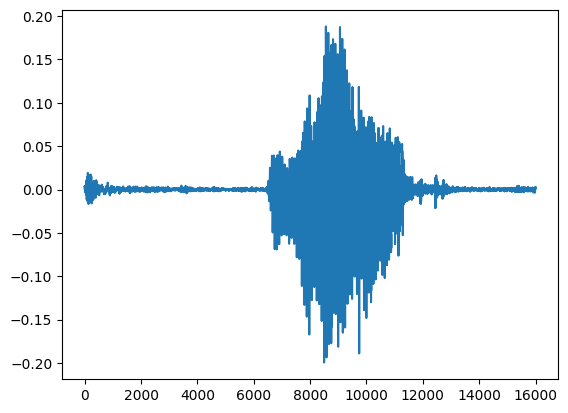

In [11]:
plt.plot(audios[4])

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import Model

inp = L.Input((iLen,), name='input')
mel_spec = audioUtils.normalized_mel_spectrogram(inp)
melspecModel = Model(inputs=inp, outputs=mel_spec, name='normalized_spectrogram_model')

melspecModel.summary()

Model: "normalized_spectrogram_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 16000)]      0           []                               
                                                                                                  
 tf.signal.stft (TFOpLambda)    (None, 125, 513)     0           ['input[0][0]']                  
                                                                                                  
 tf.math.abs (TFOpLambda)       (None, 125, 513)     0           ['tf.signal.stft[0][0]']         
                                                                                                  
 tf.tensordot (TFOpLambda)      (None, 125, 80)      0           ['tf.math.abs[0][0]']            
                                                                       

In [13]:
audios.shape

(32, 16000)

In [14]:
melspec = melspecModel.predict(audios)
melspec.shape

np.min(melspec[9,:,:].T), np.max(melspec[9,:,:].T), np.mean(melspec[9,:,:].T)

1/1 [==============================] - 1s 749ms/step


(-2.491063, 2.2515063, -0.0690012)

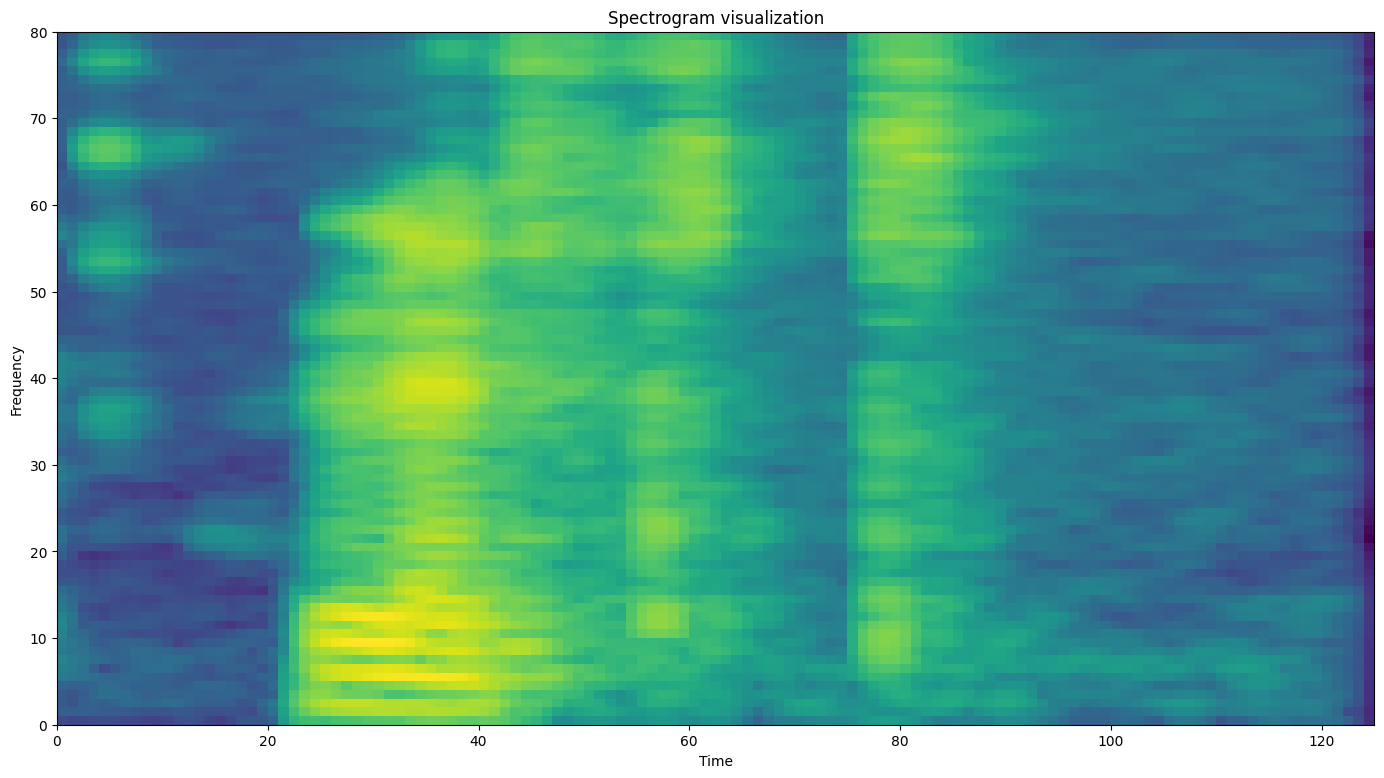

In [15]:
plt.figure(figsize=(17,9))
plt.pcolormesh(melspec[9,:,:].T)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [16]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)
np.min(S_dB), np.max(S_dB)

(-54.27316876887532, 0.0)

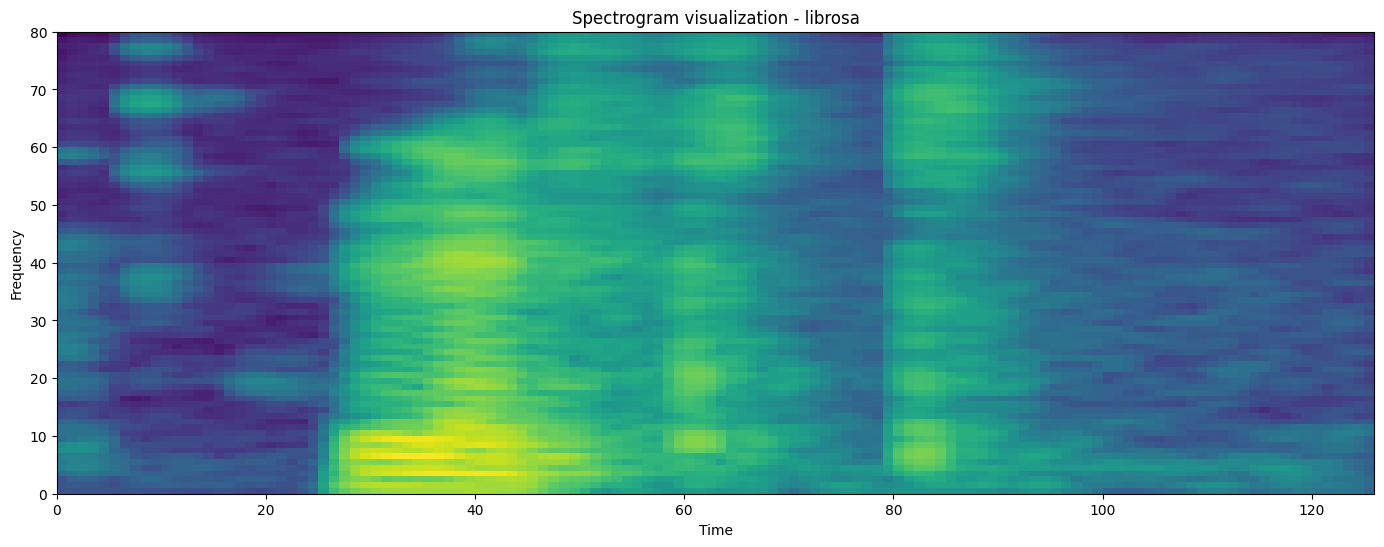

In [17]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [20]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Lambda, Bidirectional, LSTM, Dense, Reshape, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K

Model

In [21]:
model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate=sr, inputLength=None)  # , rnn_func=L.LSTM)

# Get the attVector from the model
attVector = model.get_layer('dot_1').output

# Branch from dot_3 layer
branch_layer = attVector

# Add layers to the branch
x = Dense(64, activation='relu')(branch_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(nCategs, activation='softmax')(x)

# Create a new model with the branch
new_model = Model(inputs=model.inputs, outputs=[model.outputs[0], output_layer])

new_model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
                  loss_weights=[1.0, 1.0], metrics=['sparse_categorical_accuracy'])
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 normalized_spectrogram_model (  (None, None, 80)    0           ['input[0][0]']                  
 Functional)                                                                                      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, None, 80, 1)  0           ['normalized_spectrogram_model[0]
                                                                 [0]']                            
                                                                                            

In [25]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,
            math.floor((1+epoch)/epochs_drop))

    if (lrate < 1e-5):
        lrate = 1e-5

    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [27]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = new_model.fit(trainGen, validation_data=valGen, epochs=10, use_multiprocessing=False, workers=4, verbose=1,
                    callbacks=[earlystopper, checkpointer, lrate])

new_model.save('model-attRNN.h5')

Changing learning rate to 0.001
Epoch 1/10
2651/2651 [==============================] - ETA: 0s - loss: 1.9710 - output_loss: 0.8753 - dense_5_loss: 1.0957 - output_sparse_categorical_accuracy: 0.7494 - dense_5_sparse_categorical_accuracy: 0.6996

2651/2651 [==============================] - 2275s 854ms/step - loss: 1.9710 - output_loss: 0.8753 - dense_5_loss: 1.0957 - output_sparse_categorical_accuracy: 0.7494 - dense_5_sparse_categorical_accuracy: 0.6996 - val_loss: 0.7069 - val_output_loss: 0.3428 - val_dense_5_loss: 0.3641 - val_output_sparse_categorical_accuracy: 0.9033 - val_dense_5_sparse_categorical_accuracy: 0.8987 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/10
2651/2651 [==============================] - ETA: 0s - loss: 0.7455 - output_loss: 0.3180 - dense_5_loss: 0.4275 - output_sparse_categorical_accuracy: 0.9059 - dense_5_sparse_categorical_accuracy: 0.8829

2651/2651 [==============================] - 2219s 837ms/step - loss: 0.7455 - output_loss: 0.3180 - dense_5_loss: 0.4275 - output_sparse_categorical_accuracy: 0.9059 - dense_5_sparse_categorical_accuracy: 0.8829 - val_loss: 0.5592 - val_output_loss: 0.2707 - val_dense_5_loss: 0.2885 - val_output_sparse_categorical_accuracy: 0.9218 - val_dense_5_sparse_categorical_accuracy: 0.9205 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/10
2651/2651 [==============================] - ETA: 0s - loss: 0.5611 - output_loss: 0.2379 - dense_5_loss: 0.3232 - output_sparse_categorical_accuracy: 0.9292 - dense_5_sparse_categorical_accuracy: 0.9121

2651/2651 [==============================] - 2230s 841ms/step - loss: 0.5611 - output_loss: 0.2379 - dense_5_loss: 0.3232 - output_sparse_categorical_accuracy: 0.9292 - dense_5_sparse_categorical_accuracy: 0.9121 - val_loss: 0.4924 - val_output_loss: 0.2385 - val_dense_5_loss: 0.2539 - val_output_sparse_categorical_accuracy: 0.9313 - val_dense_5_sparse_categorical_accuracy: 0.9323 - lr: 0.0010
Changing learning rate to 0.001
Epoch 4/10
2651/2651 [==============================] - ETA: 0s - loss: 0.4556 - output_loss: 0.1941 - dense_5_loss: 0.2615 - output_sparse_categorical_accuracy: 0.9419 - dense_5_sparse_categorical_accuracy: 0.9265

2651/2651 [==============================] - 2243s 846ms/step - loss: 0.4556 - output_loss: 0.1941 - dense_5_loss: 0.2615 - output_sparse_categorical_accuracy: 0.9419 - dense_5_sparse_categorical_accuracy: 0.9265 - val_loss: 0.4529 - val_output_loss: 0.2189 - val_dense_5_loss: 0.2341 - val_output_sparse_categorical_accuracy: 0.9379 - val_dense_5_sparse_categorical_accuracy: 0.9362 - lr: 0.0010
Changing learning rate to 0.001
Epoch 5/10
2651/2651 [==============================] - ETA: 0s - loss: 0.3969 - output_loss: 0.1676 - dense_5_loss: 0.2294 - output_sparse_categorical_accuracy: 0.9495 - dense_5_sparse_categorical_accuracy: 0.9359

2651/2651 [==============================] - 2260s 852ms/step - loss: 0.3969 - output_loss: 0.1676 - dense_5_loss: 0.2294 - output_sparse_categorical_accuracy: 0.9495 - dense_5_sparse_categorical_accuracy: 0.9359 - val_loss: 0.4289 - val_output_loss: 0.2067 - val_dense_5_loss: 0.2222 - val_output_sparse_categorical_accuracy: 0.9390 - val_dense_5_sparse_categorical_accuracy: 0.9353 - lr: 0.0010
Changing learning rate to 0.001
Epoch 6/10
2651/2651 [==============================] - ETA: 0s - loss: 0.3504 - output_loss: 0.1482 - dense_5_loss: 0.2022 - output_sparse_categorical_accuracy: 0.9547 - dense_5_sparse_categorical_accuracy: 0.9421

2651/2651 [==============================] - 2254s 850ms/step - loss: 0.3504 - output_loss: 0.1482 - dense_5_loss: 0.2022 - output_sparse_categorical_accuracy: 0.9547 - dense_5_sparse_categorical_accuracy: 0.9421 - val_loss: 0.4597 - val_output_loss: 0.2261 - val_dense_5_loss: 0.2336 - val_output_sparse_categorical_accuracy: 0.9385 - val_dense_5_sparse_categorical_accuracy: 0.9378 - lr: 0.0010
Changing learning rate to 0.001
Epoch 7/10
2651/2651 [==============================] - ETA: 0s - loss: 0.3131 - output_loss: 0.1304 - dense_5_loss: 0.1827 - output_sparse_categorical_accuracy: 0.9604 - dense_5_sparse_categorical_accuracy: 0.9480

2651/2651 [==============================] - 2244s 846ms/step - loss: 0.3131 - output_loss: 0.1304 - dense_5_loss: 0.1827 - output_sparse_categorical_accuracy: 0.9604 - dense_5_sparse_categorical_accuracy: 0.9480 - val_loss: 0.4423 - val_output_loss: 0.2200 - val_dense_5_loss: 0.2223 - val_output_sparse_categorical_accuracy: 0.9422 - val_dense_5_sparse_categorical_accuracy: 0.9414 - lr: 0.0010
Changing learning rate to 0.001
Epoch 8/10
2651/2651 [==============================] - ETA: 0s - loss: 0.2893 - output_loss: 0.1204 - dense_5_loss: 0.1688 - output_sparse_categorical_accuracy: 0.9636 - dense_5_sparse_categorical_accuracy: 0.9532

2651/2651 [==============================] - 2247s 848ms/step - loss: 0.2893 - output_loss: 0.1204 - dense_5_loss: 0.1688 - output_sparse_categorical_accuracy: 0.9636 - dense_5_sparse_categorical_accuracy: 0.9532 - val_loss: 0.4648 - val_output_loss: 0.2309 - val_dense_5_loss: 0.2340 - val_output_sparse_categorical_accuracy: 0.9399 - val_dense_5_sparse_categorical_accuracy: 0.9415 - lr: 0.0010
Changing learning rate to 0.001
Epoch 9/10
2651/2651 [==============================] - ETA: 0s - loss: 0.2600 - output_loss: 0.1069 - dense_5_loss: 0.1531 - output_sparse_categorical_accuracy: 0.9674 - dense_5_sparse_categorical_accuracy: 0.9562

2651/2651 [==============================] - 2307s 870ms/step - loss: 0.2600 - output_loss: 0.1069 - dense_5_loss: 0.1531 - output_sparse_categorical_accuracy: 0.9674 - dense_5_sparse_categorical_accuracy: 0.9562 - val_loss: 0.4341 - val_output_loss: 0.2156 - val_dense_5_loss: 0.2184 - val_output_sparse_categorical_accuracy: 0.9447 - val_dense_5_sparse_categorical_accuracy: 0.9439 - lr: 0.0010
Changing learning rate to 0.001
Epoch 10/10
2651/2651 [==============================] - ETA: 0s - loss: 0.2401 - output_loss: 0.0983 - dense_5_loss: 0.1417 - output_sparse_categorical_accuracy: 0.9698 - dense_5_sparse_categorical_accuracy: 0.9593

2651/2651 [==============================] - 2290s 864ms/step - loss: 0.2401 - output_loss: 0.0983 - dense_5_loss: 0.1417 - output_sparse_categorical_accuracy: 0.9698 - dense_5_sparse_categorical_accuracy: 0.9593 - val_loss: 0.4470 - val_output_loss: 0.2236 - val_dense_5_loss: 0.2234 - val_output_sparse_categorical_accuracy: 0.9440 - val_dense_5_sparse_categorical_accuracy: 0.9440 - lr: 0.0010


In [ ]:
# load best model
new_model.load_weights('model-attRNN.h5')

In [ ]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [ ]:
valEval = new_model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = new_model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = new_model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(new_model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'output_loss', 'dense_5_loss', 'output_sparse_categorical_accuracy', 'dense_5_sparse_categorical_accuracy'] 
Train: [0.18504832684993744, 0.09002819657325745, 0.09501993656158447, 0.9717087745666504, 0.9714258909225464] 
Validation: [0.44592270255088806, 0.2220238894224167, 0.2238987684249878, 0.9446342587471008, 0.9440313577651978] 
Test: [0.482374370098114, 0.23991920053958893, 0.24245505034923553, 0.9370286464691162, 0.9372103810310364]


In [41]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = new_model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = new_model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

# Evaluation and Attention Plots

In [42]:
attSpeechModel = Model(inputs=new_model.input,
                                 outputs=[new_model.get_layer('output').output,
                                          new_model.get_layer('attSoftmax').output,
                                          new_model.get_layer('tf.expand_dims').output])

In [ ]:
audios, classes = valGen.__getitem__(3)
classes

array([35, 27,  9, 28, 12,  3, 12, 20, 35, 17,  8, 10,  1,  8, 14,  2, 34,
        6, 18, 12, 19, 21, 14, 15, 10, 24, 10, 17, 24, 34, 17, 16])

In [ ]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

35

In [ ]:
outs, attW, specs = attSpeechModel.predict(audios)

1/1 [==============================] - 3s 3s/step


In [ ]:
np.argmax(outs,axis=1)

array([35, 16,  9, 28, 12,  3, 12, 20, 35, 17,  8, 10,  1,  8, 14,  2, 34,
        6, 18, 12, 19, 21, 14, 15, 10, 24, 10, 17, 24, 34, 17, 16])

In [ ]:
specs.shape

(32, 125, 80, 1)

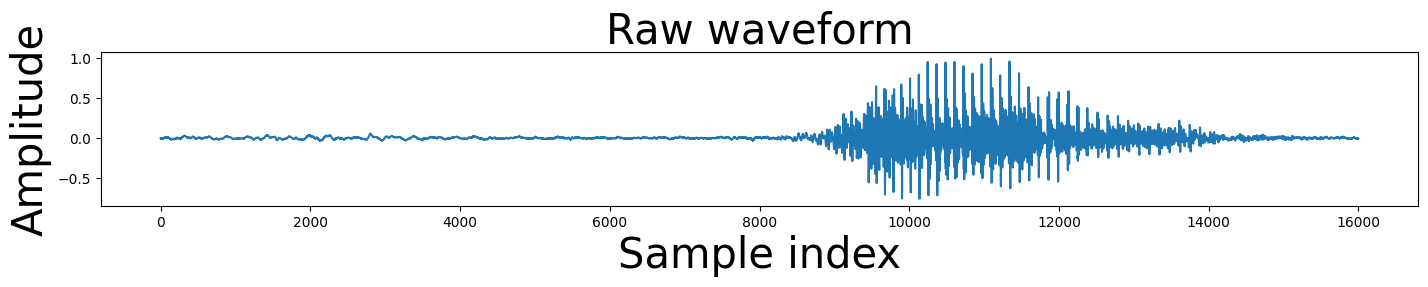

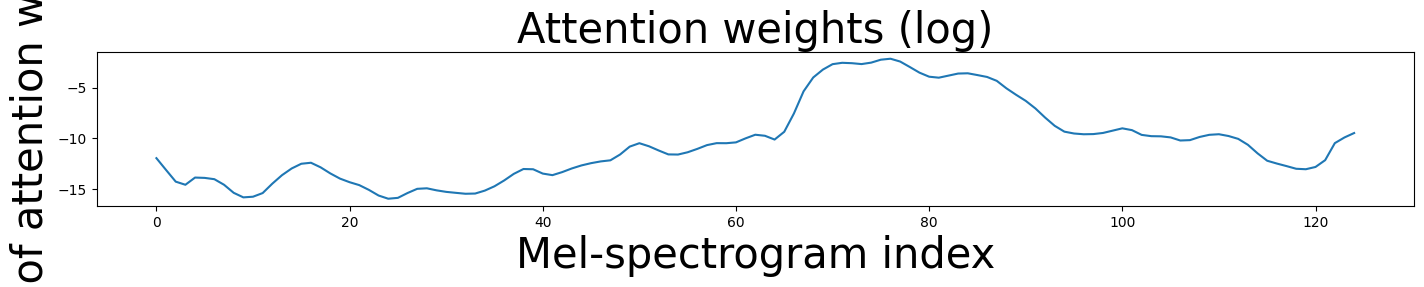

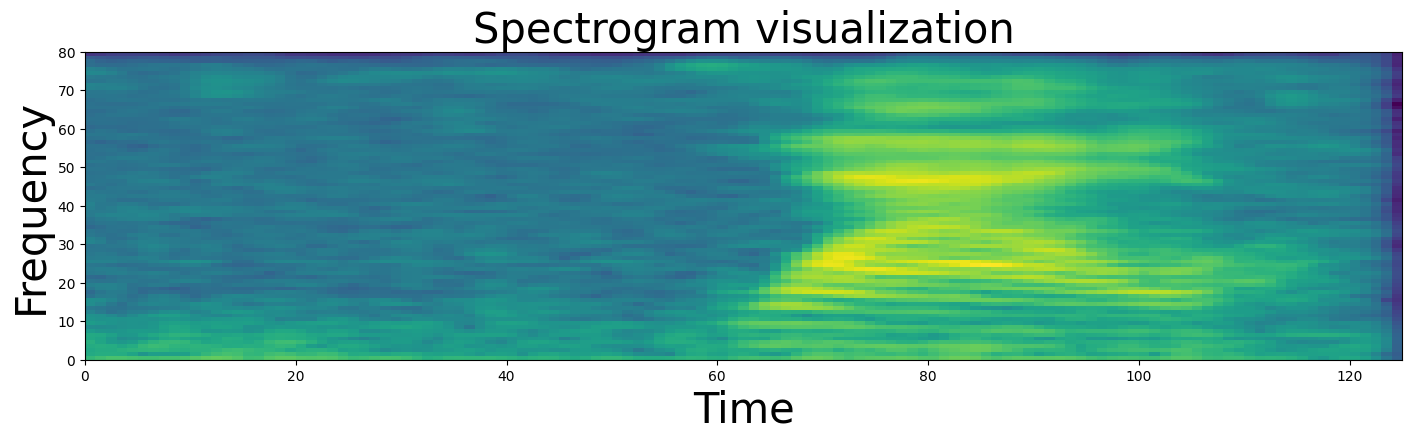

In [ ]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0].T)

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [ ]:
y_pred = new_model.predict(x_test, verbose=1)

344/344 [==============================] - 121s 344ms/step
